# Ejercicio 1 - Indexado BSBI y corpus de Wikipedia

In [2]:
import os
import time
import matplotlib.pyplot as plt
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from lib.IndexadorBSBI import IndexadorBSBI
from lib.Tokenizador import Tokenizador

CORPUS_PATH: str = "../datos/"
INDEX_DIR: str = "../index"


# Analiza la colección: cuenta documentos y suma tamaño total (solo .txt y .html)
def analizar_corpus(corpus_path: str) -> tuple[int, int]:
    total_docs: int = 0
    total_size: int = 0
    for root, _, files in os.walk(corpus_path):
        for fname in files:
            if fname.endswith((".txt", ".html")):
                total_docs += 1
                total_size += os.path.getsize(os.path.join(root, fname))
    return total_docs, total_size


total_docs: int
size_corpus: int
total_docs, size_corpus = analizar_corpus(CORPUS_PATH)
print(f"Total de documentos en la colección: {total_docs}")
print(f"Tamaño total de la colección: {size_corpus/1024/1024:.2f} MB")

Total de documentos en la colección: 6043
Tamaño total de la colección: 146.01 MB


## Prueba con varios valores de n (10%, 20%, 50% del total)

In [3]:
from typing import List, Dict, Any

n_values = [max(1, int(total_docs * frac)) for frac in [0.1, 0.2, 0.5]]
resultados: List[Dict[str, Any]] = []

for n in n_values:
    print(f"\nIndexando con n = {n} (volcado cada {n} documentos)...")
    tokenizer = Tokenizador()
    indexador = IndexadorBSBI(tokenizer, memory_limit=n, path_index=f"{INDEX_DIR}_n{n}")

    # Indexación
    t0 = time.time()
    indexador.index_collection(CORPUS_PATH)
    t1 = time.time()
    sizes = indexador.index_size_on_disk()
    posting_sizes = indexador.posting_list_sizes()

    resultados.append(
        {
            "n": n,
            "tiempo_total": t1 - t0,
            "size_postings": sizes["size_postings"],
            "size_vocab": sizes["size_vocab"],
            "posting_sizes": posting_sizes,
        }
    )


Indexando con n = 604 (volcado cada 604 documentos)...
Iniciando indexado (BSBI)...
Procesando documento 6043: 0_(number).htmlfor_Best_Dialogue_d7c1.htmlmltmlnia)_45c5.htmlhtml9020.html1.htmlmlmlef3b.htmltml
Tiempo de indexado (volcado parcial): 142.94 segundos
Iniciando merge de chunks...
Escribiendo skips en ../index_n604/skips.pkl
Tiempo de merge: 6.96 segundos
Escribiendo vocabulario en ../index_n604/vocabulary.pkl
Escribiendo metadata en ../index_n604/metadata.pkl

Indexando con n = 1208 (volcado cada 1208 documentos)...
Iniciando indexado (BSBI)...
Procesando documento 6043: 0_(number).htmlfor_Best_Dialogue_d7c1.htmlmltmlnia)_45c5.htmlhtml9020.html1.htmlmlmlef3b.htmltml
Tiempo de indexado (volcado parcial): 137.05 segundos
Iniciando merge de chunks...
Escribiendo skips en ../index_n1208/skips.pkl
Tiempo de merge: 6.87 segundos
Escribiendo vocabulario en ../index_n1208/vocabulary.pkl
Escribiendo metadata en ../index_n1208/metadata.pkl

Indexando con n = 3021 (volcado cada 3021 do

In [4]:
print("Resultados:")
for i, r in enumerate(resultados):
    print(f"n={r['n']}:")
    print(f"  Tiempo total: {r['tiempo_total']:.2f} segundos")
    print(f"  Tamaño del índice en disco: {r['size_postings'] + r['size_vocab']} bytes")
    print(f"  Tamaño de postings: {r['size_postings']} bytes")
    print(f"  Tamaño de vocabulario: {r['size_vocab']} bytes")
    print(f"  Cantidad de posting lists: {len(r['posting_sizes'])}")
    print(f"  Tamaño máximo de posting list: {max(r['posting_sizes'])}")

Resultados:
n=604:
  Tiempo total: 150.07 segundos
  Tamaño del índice en disco: 20797096 bytes
  Tamaño de postings: 15735720 bytes
  Tamaño de vocabulario: 5061376 bytes
  Cantidad de posting lists: 198216
  Tamaño máximo de posting list: 6043
n=1208:
  Tiempo total: 144.10 segundos
  Tamaño del índice en disco: 20797096 bytes
  Tamaño de postings: 15735720 bytes
  Tamaño de vocabulario: 5061376 bytes
  Cantidad de posting lists: 198216
  Tamaño máximo de posting list: 6043
n=3021:
  Tiempo total: 143.34 segundos
  Tamaño del índice en disco: 20797096 bytes
  Tamaño de postings: 15735720 bytes
  Tamaño de vocabulario: 5061376 bytes
  Cantidad de posting lists: 198216
  Tamaño máximo de posting list: 6043


## Gráfica: Tiempos de indexación para cada valor de N

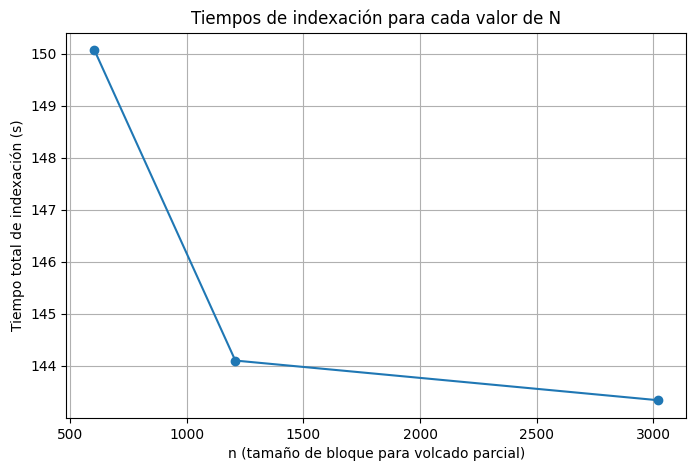

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(
    [r["n"] for r in resultados], [r["tiempo_total"] for r in resultados], marker="o"
)
plt.xlabel("n (tamaño de bloque para volcado parcial)")
plt.ylabel("Tiempo total de indexación (s)")
plt.title("Tiempos de indexación para cada valor de N")
plt.grid(True)
plt.show()

## Gráfica: Distribución de tamaños de posting lists
La distribución es la misma para los tres tamaños de N (solo se muestra un caso).

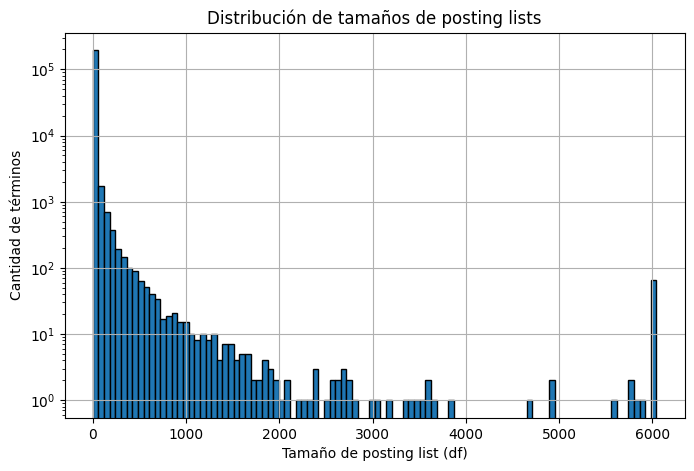

In [6]:
plt.figure(figsize=(8, 5))
plt.hist(resultados[0]["posting_sizes"], bins=100, edgecolor="black", log=True)
plt.xlabel("Tamaño de posting list (df)")
plt.ylabel("Cantidad de términos")
plt.title("Distribución de tamaños de posting lists")
plt.grid(True)
plt.show()

## Cálculo del overhead del índice respecto de la colección

In [7]:
for r in resultados:
    overhead = (r["size_postings"] + r["size_vocab"]) / size_corpus
    print(f"n={r['n']}: Overhead del índice = {overhead*100:.2f}%")

n=604: Overhead del índice = 13.58%
n=1208: Overhead del índice = 13.58%
n=3021: Overhead del índice = 13.58%
